# Deep Learning: Mastering Neural Networks - Module 5: Introduction to RNNs and NLP in PyTorch

Up until this point, we have yet to apply the power of PyTorch to solving Natural Language Processing (NLP) problems. The field of NLP is an extremely exciting space to apply Deep Learning techniques. Just like in Computer Vision, there are different classes of NLP problems. These include classification, summarization, sequence to sequence mapping, and others. Eventually, we would like to implement a model that solves an extremely popular sequence to sequence mapping problem: Machine Translation. In order to build our NLP toolset though, we will first examine the simpler tasks of word and sentence completion.

## Problem Definition

Sequence to Sequence Mapping problems are inherently different than the supervised learning tasks we have solved in the past. In Image Classification, there is a singular image with a singular class label, a one-to-one mapping between the input and output. In sequence to sequence mapping, our input consists of many discrete samples, or in our case - characters. Additionally, our output is a sequence of characters.


## Dataset

For our dataset, we will use a database of English-Spanish phrase pairs. Eventually we will use this same dataset for our machine translation task but first we will just be examining the English phrases.

The PyTorch Tutorial - [NLP From Scratch](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) uses an English-French dataset for a translation task and was the inspiration for our use of this dataset. We will perform some similar dataset cleaning and utility functions as they do in their tutorial.

In [ ]:
from io import open
import unicodedata
import string
import random
import re

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Subset
from torch.utils.data import TensorDataset, DataLoader
import time, copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Here we download and unzip the text file that contains all of our translated phrases
!rm spa-eng.zip _about.txt spa.txt
!wget https://www.manythings.org/anki/spa-eng.zip
!unzip spa-eng.zip
!ls

rm: cannot remove 'spa-eng.zip': No such file or directory
rm: cannot remove '_about.txt': No such file or directory
rm: cannot remove 'spa.txt': No such file or directory
--2022-10-19 14:18:40--  https://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5336731 (5.1M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   5.09M  19.8MB/s    in 0.3s    

2022-10-19 14:18:41 (19.8 MB/s) - ‘spa-eng.zip’ saved [5336731/5336731]

Archive:  spa-eng.zip
  inflating: _about.txt              
  inflating: spa.txt                 
_about.txt  sample_data  spa-eng.zip  spa.txt


These helper functions will clean our dataset and ensure the phrases can be used by our neural network. For more information please check out the link in the comments.

In [ ]:
# Helper functions combined from PyTorch tutorial: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
# This is important because we want all words to be formatted the same similar
# to our image normalization
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!'?]+", r" ", s)
    return s

def parse_data(filename):
    # Read the file and split into lines
    lines = open(filename, encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    # Throw out the attribution as it is not a part of the data
    pairs = [[pair[0], pair[1]] for pair in pairs]

    return pairs

In [ ]:
pairs = parse_data("spa.txt")
# We only want the english sentences because we aren't translating
english_sentences = [pair[0] for pair in pairs]
# Shuffle our dataset
random.shuffle(english_sentences)
print("Number of English sentences:", len(english_sentences))

Number of English sentences: 139013


In [ ]:
# We will include all ascii letters and some common characters for our valid character set
letters = string.ascii_letters + " .,;'-"
num_letters = len(letters) + 1 # Need to add 1 for the End Tag

## Word Completion

For our first pass, we will take a sample of the words from our sentences and predict complete words given a subset of characters!

In [ ]:
# Strip all of our phrases down to words and throw out '.'
words = [word for sentence in english_sentences for word in sentence.split(' ') if word not in ['.', '!', '?'] and len(word) > 0 and '\'' not in word]

# Since we already shuffled our dataset, grab a random sampling of words for our train, val, and test
train_words = words[:20000]
val_words = words[20000:25000]
test_words = words[25000:30000]

### Encoding

Now that we have all of our words in string format, we need to encode them in a representation that the neural network can understand. We will create a one hot encoding vector for each character and concatenate those to represent a specific word for our input training samples.

Since we are using a RNN, we will be feeding each of these character vectors in one at a time. The goal of the RNN is to predict the *next* character in the word. This allows the network to generate a word given a single letter or a prefix. Additionally, we need the network to learn when the end of a word is. To achieve this, we will designate a special character for the end of a given sequence (`<EOS>`) that should be predicted by the last character in a word.

Therefore, we will designate two tensor sequences. First we create the `input_tensor` which is represented as the concatenation of the one hot encoding vectors for each character. The second tensor sequence, `target_tensor` contains the one hot encoding vector for the target characters corresponding to each character in the input tensor. For example, the `input_tensor`,`target_tensor` character correspondance for the word "apple" is:

`input_tensor = "apple"`

`target_tensor = "pple<EOS>`



In [ ]:
# Now make our training samples:

# Adapted from https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html
# One-hot matrix of first to last letters (not including EOS) for input
def input_tensor(word):
    tensor = torch.zeros(len(word), 1, num_letters)
    for idx in range(len(word)):
        letter = word[idx]
        tensor[idx][0][letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def target_tensor(word):
    tensor = torch.zeros(len(word), 1, num_letters)
    for idx in range(1, len(word)):
        letter = word[idx]
        tensor[idx-1][0][letters.find(letter)] = 1
    tensor[len(word)-1][0][num_letters-1] = 1 # EOS
    return tensor

train_input = [input_tensor(word) for word in train_words]
train_target = [target_tensor(word) for word in train_words]
val_input = [input_tensor(word) for word in val_words]
val_target = [target_tensor(word) for word in val_words]
test_input = [input_tensor(word) for word in test_words]
test_target = [target_tensor(word) for word in test_words]

In [ ]:
# Let's look at a few word encodings, to see what those look like:
for i in range(6):
    print(train_words[i], "[encode as]", train_input[i])

do [encode as] tensor([[[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]]])
you [encode as] tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [ ]:
# Now let's look at the pairing of the input_tensors to the target_tensors
def input_tensor_to_word(tensor):
    word = ""
    for i in range(tensor.size(0)):
        topv, topi = tensor[i].topk(1)
        word += letters[topi[0][0]]
    return word

def target_tensor_to_word(tensor):
    word = ""
    for i in range(tensor.size(0)):
        topv, topi = tensor[i].topk(1)
        if topi[0][0] == num_letters-1:
            word += "<EOS>"
            break
        word += letters[topi[0][0]]
    return word
print("This code helps visualize which characters represent an input_tensor and its corresponding target_tensor")
examples_to_show = 6
count = 1
for input, target in zip(train_input, train_target):
    print(input_tensor_to_word(input))
    print(target_tensor_to_word(target))
    count += 1
    if count > examples_to_show:
        break


This code helps visualize which characters represent an input_tensor and its corresponding target_tensor
do
o<EOS>
you
ou<EOS>
know
now<EOS>
which
hich<EOS>
room
oom<EOS>
the
he<EOS>


In [ ]:
dataloaders = {'train': list(zip(train_input, train_target)),
               'val': list(zip(val_input, val_target)),
               'test': list(zip(test_input, test_target))}

dataset_sizes = {'train': len(train_input),
                 'val': len(val_input),
                 'test': len(test_input)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 20000, 'val': 5000, 'test': 5000}


### RNN Definition

The model we create to solve this task will be a basic implementation of a Recurrent Neural Network (RNN). Luckily for us, PyTorch has a great implementation of an RNN module. We will use this built in RNN module and modify our standard `forward` method to account for the hidden state!

By using an RNN, our neural network is able to make predictions on sequences of characters. Our forward pass will be slightly modified and include a hidden state that encodes information about the current sequence that the neural network has already seen. In addition to the encoded hidden state, the output of our forward pass will be the predicted probabilities for the next character in the sequence.

Our training will be slightly different as the network will be predicting probabilities for the next character in the entire sequence, so we will be keeping track of the loss for an entire sequence before performing back propagation. We will explain this in more depth below.


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.rnn = nn.RNN(input_size, hidden_size, num_layers = 1, nonlinearity = 'tanh', dropout = 0)

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):

        output, hidden = self.rnn(input, hidden)
        output = self.fc(output)

        return output, hidden

    # This method will give us a hidden state tensor to use for our initial prediction of the sequence
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [ ]:
# We will use a hidden size of 128 for this network
word_rnn = RNN(num_letters, 128, num_letters).to(device)

### Training

Training the model will be very similar to classification tasks we have done in the past, however we will now account for the sequence of inputs and predictions. When training, we will calculate the loss for an entire sequence of characters (word) and perform back propagation at the end of a given sequence.

We can define the steps for a given sequence below:

1. Initialize the hidden state - Each call of `forward` requires a hidden state encoding. We have decided that our initial hidden state encoding for the first character in a sequence is a `zeros` tensor.
2. Loop through the `input_tensor` and perform the following steps for each character in the sequence:

    a. Call `forward` with the current character's encoding and the current `hidden_state`.

    b. `forward` will output a probability distribution of the next predicted character and a new `hidden_state`

    c. Calculate the loss of the output probability distribution of the next character with respect to the ground truth next character in the sequence and add it to the running total.

    d. Continue to the next character in the input sequence using the latest `hidden_state`
3. Once all of the characters in the sequence have been fed through the `forward` function, perform backpropagation given the entire loss of the sequence and redo this process for the next sequence.

Note: our training function has been updated to represent this new workflow. Try and walk through the comments in the code to see how we implemented this new process in Python!



In [ ]:
def train_rnn(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # keep the best weights stored separately
    best_loss = np.inf
    best_epoch = 0

    # Each epoch has a training, validation, and test phase
    phases = ['train', 'val', 'test']

    # Keep track of how loss evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data
            for input_sequence, target_sequence in dataloaders[phase]:
                # Now Iterate through each sequence here:

                hidden = model.initHidden() # Start with a fresh hidden state

                current_input_sequence = input_sequence.to(device)
                current_target_sequence = target_sequence.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    loss = 0
                    # Make a prediction for each element in the sequence,
                    # keeping track of the hidden state along the way
                    for i in range(current_input_sequence.size(0)):
                        current_hidden = hidden.to(device)
                        output, hidden = model(current_input_sequence[i], current_hidden)
                        l = criterion(output, current_target_sequence[i])
                        loss += l

                    # backward + update weights only if in training phase at the end of a sequence
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() / current_input_sequence.size(0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)

            print(f'{phase:5} Loss: {epoch_loss:.4f}')

            # deep copy the model if it's the best loss
            if phase == 'val' and epoch_loss < best_loss:
              best_epoch = epoch
              best_loss = epoch_loss
              best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Loss: {best_loss:4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, training_curves

In [ ]:
# This should look very similar to our previous tasks!
learning_rate = 0.001
num_epochs = 10 # We are only doing 10 Epochs here to save time, feel free to do longer!

In [ ]:
# Very similar code to training non recurrent models before!
# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(word_rnn.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model. We also will store the results of training to visualize
word_rnn, training_curves = train_rnn(word_rnn, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/10
----------
train Loss: 1.4985
val   Loss: 1.3527
test  Loss: 1.3650

Epoch 2/10
----------
train Loss: 1.2999
val   Loss: 1.2613
test  Loss: 1.2710

Epoch 3/10
----------
train Loss: 1.2216
val   Loss: 1.2241
test  Loss: 1.2369

Epoch 4/10
----------
train Loss: 1.1778
val   Loss: 1.1934
test  Loss: 1.2065

Epoch 5/10
----------
train Loss: 1.1466
val   Loss: 1.1685
test  Loss: 1.1812

Epoch 6/10
----------
train Loss: 1.1243
val   Loss: 1.1588
test  Loss: 1.1717

Epoch 7/10
----------
train Loss: 1.1059
val   Loss: 1.1542
test  Loss: 1.1643

Epoch 8/10
----------
train Loss: 1.0916
val   Loss: 1.1385
test  Loss: 1.1477

Epoch 9/10
----------
train Loss: 1.0787
val   Loss: 1.1307
test  Loss: 1.1387

Epoch 10/10
----------
train Loss: 1.0678
val   Loss: 1.1201
test  Loss: 1.1248

Training complete in 13m 59s
Best val Loss: 1.120111 at epoch 9


### Visualizing Results

We can visualize our training curve just like in our previous tasks. Here it looks like we are not overfitting after 10 Epochs - we could probably train this net longer!

In [ ]:
def plot_training_curves(training_curves,
                         phases=['train', 'val', 'test'],
                         metrics=['loss']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                plt.plot(epochs, training_curves[key])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

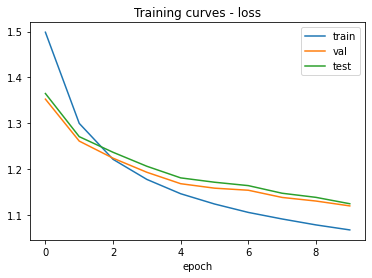

In [ ]:
plot_training_curves(training_curves, phases=['train', 'val', 'test'])

### Generating Words

Below we have included a function that runs the network on a specified input sequence. This could be one letter or part of word! We have included some examples below, see what words the network will predict for you!

The results of this network will be heavily determined by the random sample of sentences that was given at the beginning. The more a certain word appears in our training data, the more likely it is to be predicted. This is very similar to the word suggestion features you see on your smartphone keyboard!

In [ ]:
def predict(model, input_letters, max_length = 50):
    output_word = input_letters
    tensor = input_tensor(input_letters)
    hidden = model.initHidden()
    current_input_sequence = tensor.to(device)
    input = None

    for i in range(current_input_sequence.size(0)):
        current_hidden = hidden.to(device)
        output, hidden = model(current_input_sequence[i], current_hidden)

    topv, topi = output.topk(1)
    topi = topi[0][0]
    if topi == num_letters - 1:
        # print("Most likely word was our initial letters, grab the second most likely")
        topv, topi = output.topk(2)
        topi = topi[0][1]
    letter = letters[topi]
    output_word += letter
    input = input_tensor(letter)

    for i in range(len(input_letters), max_length):
        current_hidden = hidden.to(device)
        current_input = input[0].to(device)
        output, hidden = model(current_input, current_hidden)
        topv, topi = output.topk(1)
        topi = topi[0][0]
        if topi == num_letters - 1:
            # print("Hit the EOS")
            break
        letter = letters[topi]
        output_word += letter
        input = input_tensor(letter)
    return output_word

In [ ]:
print(predict(word_rnn, "ha"))
print(predict(word_rnn, "al"))
print(predict(word_rnn, "c"))

have
all
can


In [ ]:
print(predict(word_rnn, ""))

and



## Sentence Completion

Now we will turn to the task of sentence completion! This will be relatively straightforward since we will still be working with one hot encodings of sequences of characters. There are other more sophisticated ways to encode our training samples that we will discuss later on.

In [ ]:
train_sentences = english_sentences[:1000]
val_sentences = english_sentences[1000:2000]
test_sentences = english_sentences[2000:3000]

### Encoding

Our encoding here is super simple. We will use the exact same function as before, just operating on an entire sentence instead of a singular word!

In [ ]:
train_input_sentence = [input_tensor(sentence) for sentence in train_sentences]
train_target_sentence = [target_tensor(sentence) for sentence in train_sentences]
val_input_sentence = [input_tensor(sentence) for sentence in val_sentences]
val_target_sentence = [target_tensor(sentence) for sentence in val_sentences]
test_input_sentence = [input_tensor(sentence) for sentence in test_sentences]
test_target_sentence = [target_tensor(sentence) for sentence in test_sentences]

In [ ]:
dataloaders_sentences = {'train': list(zip(train_input_sentence, train_target_sentence)),
               'val': list(zip(val_input_sentence, val_target_sentence)),
               'test': list(zip(test_input_sentence, test_target_sentence))}

dataset_sizes_sentences = {'train': len(train_input_sentence),
                 'val': len(train_input_sentence),
                 'test': len(train_input_sentence)}
print(f'dataset_sizes = {dataset_sizes_sentences}')

dataset_sizes = {'train': 1000, 'val': 1000, 'test': 1000}


### RNN Definition

Additionally, we can use the exact same architecture! We will just use a larger hidden layer since our sequences will be longer.

In [ ]:
# Bigger rnn
sentences_rnn = RNN(num_letters, 256, num_letters).to(device)

### Training

Here we will train for another 10 Epochs as it takes a very long time to train recurrent models. Increasing the number of epochs should increase the performance of the model.

In [ ]:
# This should look very similar to our previous tasks!
learning_rate = 0.001
num_epochs = 10 # We are only doing 10 Epochs here to save time, feel free to do longer!

In [ ]:
# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(sentences_rnn.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model. We also will store the results of training to visualize
sentences_rnn, training_curves_sentences = train_rnn(sentences_rnn, dataloaders_sentences, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/10
----------
train Loss: 0.1212
val   Loss: 0.4222
test  Loss: 0.4225

Epoch 2/10
----------
train Loss: 0.1024
val   Loss: 0.4019
test  Loss: 0.4031

Epoch 3/10
----------
train Loss: 0.0973
val   Loss: 0.3902
test  Loss: 0.3916

Epoch 4/10
----------
train Loss: 0.0936
val   Loss: 0.3799
test  Loss: 0.3814

Epoch 5/10
----------
train Loss: 0.0904
val   Loss: 0.3738
test  Loss: 0.3752

Epoch 6/10
----------
train Loss: 0.0875
val   Loss: 0.3711
test  Loss: 0.3727

Epoch 7/10
----------
train Loss: 0.0848
val   Loss: 0.3679
test  Loss: 0.3694

Epoch 8/10
----------
train Loss: 0.0822
val   Loss: 0.3654
test  Loss: 0.3667

Epoch 9/10
----------
train Loss: 0.0796
val   Loss: 0.3634
test  Loss: 0.3651

Epoch 10/10
----------
train Loss: 0.0772
val   Loss: 0.3605
test  Loss: 0.3626

Training complete in 6m 24s
Best val Loss: 0.360483 at epoch 9


### Visualizing Results

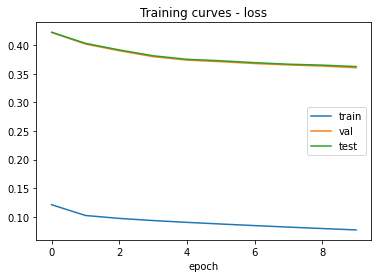

In [ ]:
plot_training_curves(training_curves_sentences, phases=['train', 'val', 'test'])

### Generating Sentences

We can use the exact same function as before with our new model in order to generate sentences. Try some of your own examples below!

In [ ]:
print(predict(sentences_rnn, "I ate a "))

I ate a los .


In [ ]:
print(predict(sentences_rnn, "What is"))

What is my for the shere .


In [ ]:
print(predict(sentences_rnn, "My name is"))

My name is the reand .


In [ ]:
print(predict(sentences_rnn, "Ha"))

Hat you den't le the thing this .


In [ ]:
print(predict(sentences_rnn, "A"))

Ao mand mary .


## Conclusions

In this notebook we have seen how to apply our powerful deep neural networks to different sequence based prediction tasks. We can see from the sentence completion results that our network does not produce super intelligent results. In future notebooks we will examine ways to improve our models and tackling more challenging tasks such as machine translation.

Some of the methods to increase performance are: Larger datasets, increased training time, more intelligent word level embeddings (word2vec), and more sophisticated deep neural networks (LSTMs and Transformers).